In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun2_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x


In [4]:
def track_smear1(kinetic_energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))

def track_smear2(energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*(energy), abs(c_hres+theta))

In [5]:
hists = {}
hists["Target_pion_ke"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("ke", r"Kinetic Energy [MeV]", 80, 0, 2000),
                                hist.Bin("e", r"Energy [MeV]", 80, 0, 2000),
                            )       

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['TSP_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['TSP_Kaon_dau2']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    
    mask_2dau = (target_kaon_dau1.gd==0)
    kshort_mask = (abs(target_kaon_dau1.mompdgID)==kshort_pdgid)
    pidau1_mask = (abs(target_kaon_dau1.pdgID)==chargedpion_pdgid)

 
    pi1 = get_vector(target_kaon_dau1[pidau1_mask & kshort_mask & mask_2dau])

    #print(flat(pi1.theta).size)
    #print((flat(pi1.t) - pion_mass).size)
    
    new_energy1 = track_smear1(pi1.t - pion_mass, pi1.theta)[0]
    new_theta1 = track_smear1(pi1.t - pion_mass, pi1.theta)[1]
    
    new_energy2 = track_smear2(pi1.t, pi1.theta)[0] - 139
    new_theta2 = track_smear2(pi1.t, pi1.theta)[1]
    
   # print(new_energy1)
    #print(pi1.t)
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    pi1_track_smeared =  ak.zip({"x": np.cos(new_theta1)*pi1.p,
                    "y": np.sin(new_theta1)*pi1.p,
                    "z": pi1.pz,
                    "t": new_energy1,
                    },
                    with_name="LorentzVector")
    
    #print(flat(pi1.theta))
    #print(flat(new_theta1)) these two pump out reasonable things
    
    #print(flat(np.cos(pi1.theta)))
    #print(flat(np.cos(new_theta1))) #these two pump out reasonable things
    
   # print(flat(pi1.px))

    print(flat(np.cos(new_theta1))*flat(pi1.p))
    
   # print(flat(pi1.p))
    print(flat(np.cos(pi1.theta)*pi1.p))
    
#show that px is p * theta 
#use vector that we know pi1, print pi1.px and pi1.theta, take the cos of that and multipy pi1.p
#see if track smeared can work without subtracting pion mass
    
    
    
    print(flat(pi1.mass), flat(new_energy1), flat(pi1.t))
    
    hists["Target_pion_ke"].fill(
                                 ke=flat(new_energy1),
                                 e=flat(new_energy2),
                                )
   # print()

    
    
    return

In [7]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[ 690.4718    337.9006    200.09973   153.91594   309.14017   291.89795
  980.788     258.78857   936.4958    106.46386    85.311066  756.8357
  735.3326    979.0389    118.17154  -222.78152  1101.1511    253.84753
   91.21532  1911.8282    740.0909    394.77472  1100.691     625.36316
  579.31384    63.493656  766.91223   288.7496    348.11353   231.79138
  643.89056   333.1366    747.50476  1625.9984   1332.0002   2192.826
  852.69763   466.72592   745.93823   524.8189   1762.5363    130.62196
  992.1895    777.35345   355.6643    451.18832  1283.1532    800.01373
 1331.1078   1769.3212    180.09808   627.54724  1101.5992    -59.394875
  563.7168    841.8654    415.2309    668.4848    669.8934    218.28964
  239.7451    347.00616   471.3997    123.114365  185.91974   744.7658
   56.26715  2719.5225    -54.617878  905.51135   563.4767    -40.593563
  686.0962   2553.5317   1854.0087    -70.35615  1211.1489    221.81903
  629.18756   924.37024   238.63046   675.5338    690.94

process 2
[ 679.74695   286.26358  1443.6168    -82.18847  1331.4194    915.6123
  647.93225  -116.69074    68.33271   519.5055    262.2306    370.1096
  641.8375   2029.5901    -18.660027  231.00827  1237.4113    957.62976
 2376.8467   -110.25103   -95.64096  1916.9341    306.8376     50.623344
  174.85097   209.06952   590.937     449.41116   369.989     -45.322933
  312.60602   -42.50505   172.45052   302.12057  -178.04721   214.98766
 2486.039     398.4781   1067.9587    841.2998    918.4039   1633.0936
  554.2854    920.3541    226.381     232.73222  1058.7462    330.8168
  572.21423  1098.6548    190.33113   571.9467    691.4669    230.51575
 1244.7194    106.75432   789.8385   2779.4507   1039.4551    322.92145
  108.50442   280.49548  2344.8037    441.99875   464.1828    471.29303
  605.2727    356.15735   644.71185   857.42944   514.7635    717.7086
  -11.454003  133.83311   755.8492    317.3842   1510.6444    382.3618
  714.15125   760.8501    -70.37032   621.45605   353.1047

process 3
[  52.8229    712.02466  1818.4034    956.4561    902.0479   1897.5726
  431.60864   269.90408    95.895676 1642.7913    521.32495   -40.649925
  669.3331    453.22534  1359.281     816.4709    708.73706   451.56815
  165.44858   357.97406   272.96347   928.10004   673.5413    816.46356
  321.0506   1213.9563   1010.52295   615.1733    704.7457   1684.5209
  214.95432   629.9751    178.73235   674.33655   -15.90134   214.14056
  760.7842    619.86664  1030.8318    168.20874  1446.8116    144.50807
  697.3717   1115.1398    271.0637   -114.15266   325.3342    266.1969
 1460.3801    398.0443    273.35342   -36.782593  762.0329    251.46791
  659.75146   316.7208    363.6344    -54.317444  970.5027    610.91364
 -100.55636   781.7861    699.5305     76.34506   679.6276    151.07504
  851.282     522.4732   1671.7601    559.1278    -39.694176  959.35785
 -212.84157   339.4934   1091.0898   -124.95014   -85.56084   643.0844
 1286.9099    302.07483  1555.1815    227.18382   432.460

process 4
[ 815.739     -44.988796  559.7531    -66.55589   643.2006    176.17723
  258.76535   -86.043564  180.19534   973.0903    229.83151   600.66327
  353.90598   255.89088   143.77446   655.3229    176.79189   400.77255
  784.18945   222.24626   676.10754   551.5136    142.56784  -154.90588
  812.33075   371.92795   778.2081    949.00006   353.75653   265.34433
   79.202354  398.71866   127.36815   -21.76902  1349.3989    165.73558
  886.0966    457.2052    643.3694    761.6669    181.91867   239.61922
  401.30872   499.6386    401.61548   249.65407   625.3068     20.351906
  207.60844   847.2572    230.48514   293.18524  1406.2244    -65.85225
  821.9221   1910.8806    248.26161   215.74852   771.02386   314.2247
 2251.738     115.618805  225.1034   1041.8977    237.26353  2828.296
  620.90326  1036.7908    666.6133    509.04678  1179.9923   1131.5823
  863.3651    568.04877  1926.8215   1349.878     393.1521   1137.7366
 1038.2528   1105.161     798.9298    286.01868  1139.0521

process 5
[1503.111      882.84784   1009.4632     -83.01243    148.6843
  172.34308   2399.1873    1921.55       396.6162     -58.54319
  -42.793583   232.29868    133.8353     530.8089     253.24931
  459.5801      49.61372   1197.6602    -138.14758    -17.898973
  316.375      -85.31244    134.44142   1880.395     1410.9669
  324.72934     32.580322  -179.74231    770.1444      50.00769
  965.2077     241.88156     68.251656   193.4217     442.55276
  317.72937    731.40466    514.8056    -110.37912    745.89166
    4.0622263  848.4292     233.81775    345.8277     391.86203
  -91.450005   107.871346   845.9271     340.44815   1155.5559
  309.18896   -125.513824   -59.783497   251.82455    302.07718
 1302.8093     548.8331     890.9958    1826.8986    1472.1606
  381.74963    517.2385     766.38       944.5161    2429.3787
  279.48254    -74.66698    121.53566    242.55058    216.4789
  623.80963    508.66245   2071.801     1293.8109     463.03738
  492.0986     394.50858    256.341

process 6
[ 345.80234  1665.695     209.9697    942.7293    702.6372    530.05115
  429.5053    502.2832   2066.3853    517.95526   120.30371  1027.9338
  388.13013   -84.03899   -64.98159  2253.461     940.5942    -93.49284
  482.24222   735.49426   772.833     111.10909  2042.6993    434.8018
  431.08575   531.7375    602.19965   234.87502   405.75818   141.00716
  -76.77189   401.82797   756.0751    304.81213   287.25815   -37.507282
  760.75543   291.30804   773.28784   890.2189    283.73132   192.0771
  404.24115   560.3837    247.74135  1383.7509   -154.84402   295.95657
  492.66763   -21.931416 1195.7018    598.9375    305.33783   423.63885
  181.03946   650.7232    296.90253   208.81189   897.1671   -151.28603
  299.90472  1011.9891   1201.395     135.69946   515.8019   3011.9468
 1532.8625    327.62427   114.24996  -157.36418   158.2472   2932.1924
 -105.46471    25.038076  765.9409    326.14288   670.3372    -51.17596
  749.82764   -35.19138  -153.91882   165.61812   -70.6052

process 7
[ 2.09820630e+03  1.40393982e+03  1.30876428e+03 -1.10563431e+02
  3.10559906e+02  3.28763000e+02  4.29992737e+02  7.53737122e+02
  9.59015259e+02  4.09326569e+02  5.97788574e+02  3.97200287e+02
  1.46791626e+03  4.62053650e+02  5.30978394e+02 -8.28895340e+01
  4.33735443e+02  4.28416412e+02  1.50291504e+02  6.48129120e+01
  1.46275955e+02  6.75657166e+02  2.26696777e+02  6.81647949e+02
  5.62830994e+02  2.68307922e+02  1.10217859e+03  6.04884521e+02
  6.40864197e+02  4.09683807e+02  6.24498047e+02 -1.65962467e+01
  1.93222031e+02  8.53113770e+02  9.49106750e+02  7.25193787e+02
  3.92229584e+02  1.07676355e+03  1.09579086e+02  2.53413986e+02
  4.51691803e+02  1.85258579e+01  1.97646265e+03  5.50036194e+02
  5.08510361e+01  9.87962952e+01  8.09430420e+02  1.62966812e+02
  1.23316309e+03  7.49813354e+02  3.37007965e+02  2.51273193e+02
  3.30648956e+02  3.69680573e+02  9.24517441e+01  6.75484436e+02
 -1.05017456e+02  1.37286169e+03  2.67330139e+02  2.07775391e+02
  3.72670837e+0

process 8
[ 235.828    1384.9547     81.885574  265.79153   670.07587   379.1335
  376.85214   213.09584   -92.45968   221.41104   379.1006    378.4808
   29.257126  650.1097   1210.558     213.4627    -89.42828   792.19855
  257.1848    446.0168    -82.405815 1023.1187    196.08904   221.02348
  673.88983  1696.2799    109.390976  311.5989    579.0987   1592.9966
  402.14932  2031.5892    154.93198   102.6427    458.4149    131.66454
   57.425735 1431.3439    516.0459    747.21497  1680.7122   1136.5695
 1407.2444    667.9317   -317.36868  1444.2826    701.2874   1520.3373
  195.14374   666.32715   414.64456   996.98114   277.3624    231.83543
 -139.85768  2094.2712   1572.9047     23.228977  437.13867    83.0693
  476.88382   348.98303  1324.5839   2559.151     315.67365  -118.892006
  885.29553   479.5371    279.42877  1105.8815    122.97777   282.15555
 2551.5957    278.92     1042.4845    508.65942   126.256836  562.6731
 1308.067     -48.65715  1021.66656   298.42825  1619.905   

process 9
[ 517.1176    -83.09557   972.5943    383.08588   113.48959   682.18787
  117.15197   314.27887   672.8416   1659.4568   1705.1044    961.1157
  562.1043   1009.1023    248.7306    271.57565   283.15103  1530.1296
  207.4275   1540.6196    332.20486   695.86816  1623.1829   -134.94824
  166.57791   210.02966  1576.3867   1131.8611    323.36813   552.59937
 1111.9899    838.118     495.46313   437.2021    -34.27055   376.02304
 1313.8228    231.03201   151.23451   209.59341   665.3035    433.16888
  311.6476   1820.079     627.80414   450.35168   -11.053015 1304.1711
  235.06828   414.7951    799.7975    701.5056    706.5658    694.6281
  524.57245   220.05429  1198.7444    597.33923   944.85803   -33.458763
  301.32217  1064.7225   2061.5867    850.8162   1028.935    1442.7366
  635.08154   313.9547    771.14087   718.77203   -71.984375 2391.2456
  451.74268    84.26798   549.7878    529.0584   1293.5073    295.86014
 1106.4727    772.44196   216.68616    91.07377   548.10474

process 10
[ 517.82367   -40.27764   458.65115    76.14568    80.80933   727.31445
  331.02103  1119.1439    358.77115   426.38635   176.65709   167.49689
  629.1255   -129.71994   328.73776  1516.4565    796.94977   365.26385
 1107.0897    695.83527   505.10608   207.76047  1167.412     -15.699616
  192.13242   -23.248035  602.26746   931.52954   199.32852  1951.4672
  839.6823    201.87149  2523.5947     97.37833   607.28766   397.3138
  159.45015  1810.1012   1035.8477    392.1722    830.73425   -87.92308
  708.4579    741.73157   220.9916    690.14716   -49.577904  261.76978
  430.67786  1430.6364     70.13634   769.07336   699.824     406.37656
 1291.8417    503.52713  1039.1942    463.15988   357.80878   -36.30646
  -62.115826  699.6553   1156.8737    858.4881    437.59647   407.4227
  503.16064   325.54364   429.70947  2077.8171   1698.6116    976.2683
  -68.42501  1157.2732    490.92197   297.00925   154.99947  1231.6252
  822.4078    253.24881   168.03473   678.371     243.873

process 11
[ 317.4597    326.1293    -97.63211   134.50764  1563.2085    -83.91924
  769.6209    -77.79001  2002.4222   -128.2567    578.4297    513.96576
  530.2967    102.25757   523.8292   1144.1589    231.61359   270.93375
  337.1558    164.34839  2727.9565   -183.52094   137.60342   522.9323
  244.56325  1768.1035    398.6282    828.07007   369.35986   363.51672
  313.65375  1015.8831   1242.4606   1160.9493    973.2343    211.86047
 1617.8002   1468.8535   1334.7548    363.6782   -172.73578   373.80563
 1149.3523    876.98883   774.90936   566.4582   1140.183     335.39993
  -50.52466   -79.219376  475.568    2638.4714    264.9042   1707.2069
  402.19235   766.07086   165.87756   391.34412   463.00687    84.54307
 2640.2566     25.729128  -52.21831   -83.75153   789.6191    100.96363
  218.31819    27.099176  317.8103     73.675835 1910.7921    611.4554
 1065.3922    191.29443   364.60046   199.04189   702.65204    23.53205
 1421.272     858.20825  1057.1653    557.6535    394.10

process 12
[ 3.62020935e+02 -1.41671539e+02  1.02584790e+03  8.28588806e+02
  2.31243927e+02  8.80011719e+02  1.54873828e+03  1.31873828e+03
  1.62176743e+02  1.36164697e+03  1.19163074e+03  1.67134656e+03
 -1.35528183e+02  1.39613049e+03  8.53390808e+02  2.11609161e+02
  8.16607513e+01  1.70008759e+02  3.88501831e+02  1.37285126e+02
  4.72099915e+02  9.75558777e+02  3.71710968e+02 -3.48497963e+01
 -8.38304138e+01  3.59564026e+02  3.79477722e+02  4.81021027e+02
  2.43082016e+02  7.85046768e+01  2.32833603e+02 -7.02097988e+00
  7.97055908e+02  6.99956055e+02  4.66914612e+02  2.70761230e+03
 -7.07859268e+01  9.84597412e+02  2.56796967e+02  3.30301239e+02
  1.86562836e+02 -8.21532211e+01  3.66828522e+02 -1.74756031e+01
  4.44837891e+02  2.17728125e+03  1.85158521e+03  2.57237640e+02
  4.97631348e+02  3.18910767e+02  5.94633728e+02  7.42620850e+02
 -4.34912910e+01  1.38447119e+03  1.16076080e+02  2.86126343e+02
 -7.46363602e+01  1.86865576e+03  1.53239868e+03  5.16499878e+02
  1.19744774e+

process 13
[ 286.01514   1081.6559     -64.65595   2368.0383     214.55415
  158.68826    112.3134    1103.6393    1505.8104    2242.4731
  151.33981    991.2359    1456.857       60.60668   2006.1475
 2216.899      293.56583    690.88336   1180.4116     700.5567
  810.9699     -65.86114    758.13776   1429.8273     253.69595
  720.0276     216.10286    182.00885   -103.017876   172.40585
 2183.5327     380.33932    677.9873     -38.684418   526.8864
  246.4023     393.11984    167.13834   1022.66205    276.8675
  -20.462595  2647.096      144.70744    437.64322   -146.5745
 1130.3279     874.4603      59.423935   195.96378    607.7331
 1901.7814    1099.0568    1390.027     2385.6553     979.31683
  314.67917    660.45703    720.02905   1769.4708     277.77707
  910.9392     834.1292     349.3209     748.77264    966.846
 -207.6612     663.0415     195.69342   1590.0305     641.4949
  443.23636    -45.07483    692.94336    -26.256124  1317.4452
  -48.868904  1913.7081     -68.17754   

process 14
[ 957.90796   -54.43285   609.6928   1062.147     149.44398  1682.9502
  689.7493    445.70053   423.81012   853.71893   -61.805077  527.7395
  630.8328    265.52002  1626.1611    654.2543    562.6552    775.43884
  551.166     550.2675    689.4812    373.15677   632.1324    381.71152
  332.71692   228.73273   965.6397    857.1901    352.6898   1262.2725
  795.30096   513.6387    819.9879    727.8567    131.72916   405.40036
 1309.7627    454.9151    -64.325264  342.40536   118.80146   497.7228
  236.17062   681.0846    146.59668   732.9101   2306.3538    263.42206
  406.4826   1552.781     408.20477   318.7078   -144.33194   367.95853
  -42.957058 1274.7706    221.64034   565.3821    315.72424   539.3543
  306.2029    549.4343    -59.425884  334.37888  1504.8917    260.89136
  368.44913   231.19139  1389.3362    893.7884    339.6191    591.2037
  196.1141   1458.0374    384.6927   -206.67058   550.85077  1008.1566
  556.3496    248.93735   199.56398   356.9532    227.56541 

process 15
[ 532.18494   571.76917  -129.48857   578.80133  1469.9304    280.65408
 1499.7728    606.1198    136.32149   931.25226  1403.7842   1408.3103
  589.785    2631.748     -81.907646 1031.0656    430.57806    80.46316
  233.18163   -34.547718  226.98492   504.66748   415.06415   271.09906
  715.61597   -28.45238   669.06305   285.6592   1149.2406    889.76794
 2082.5984    555.5118    156.25223   324.61346   624.2432    650.9412
  -27.364199  443.33154   295.17215   529.8729    985.29626   -63.353146
 1693.9164    448.12366  1303.691     180.84969  1487.4739   2127.734
 -171.62839   111.99693   198.07637   -54.04894   774.8341    181.3936
  402.37097   449.80713   315.2217    388.0826    -38.173985  389.6533
  548.2164    379.0897    460.28046   323.74344   909.5386    172.14417
  704.3109    229.75868   772.87946   287.01392   257.62808   162.72287
  130.73796  -194.9079     49.414383  745.89655  1670.9586    179.49033
  468.24203   318.97794  2201.712    1947.9984     70.3972

process 16
[ 2.96403992e+02  1.08709985e+03 -5.81661377e+01  2.37070117e+03
  2.16372253e+02  1.59120102e+02  1.22244720e+02  1.11708313e+03
  1.52227197e+03  2.25356519e+03  1.60240479e+02  1.01257635e+03
  1.46185107e+03  6.59840927e+01  2.01308862e+03  2.23724927e+03
  3.03898041e+02  6.99991211e+02  1.18278748e+03  7.18114258e+02
  8.16656616e+02 -4.22045670e+01  7.61124451e+02  1.44818188e+03
  2.61679047e+02  7.34822876e+02  2.24614914e+02  1.84355453e+02
 -9.70343323e+01  1.78241699e+02  2.20032349e+03  3.93667023e+02
  7.02162048e+02 -3.58399658e+01  5.34092651e+02  2.49699799e+02
  3.98511871e+02  1.72660065e+02  1.02898621e+03  2.85720490e+02
 -1.24533701e+01  2.66716016e+03  1.55523315e+02  4.51162140e+02
 -1.44850967e+02  1.15752930e+03  8.82849304e+02  6.66716690e+01
  2.00259613e+02  6.21106750e+02  1.90535413e+03  1.10404907e+03
  1.40292322e+03  2.39932520e+03  1.00010107e+03  3.18918732e+02
  6.62138062e+02  7.40104065e+02  1.78262219e+03  2.90252533e+02
  9.18656128e+

process 17
[ 184.90059   721.15814   251.58318   346.7019    -40.757256  147.4824
  592.66125  1319.096     -44.658367  458.71616   425.0917    316.45685
  361.27496   762.4171    343.3657    388.75827   831.212     113.19446
 1122.675     -17.126299  156.95221    95.44859   738.1993    380.82596
  310.75974   943.2247    259.2646    577.99274   -73.40232   527.63446
 1049.1578    465.93353  1177.549     380.64456   488.7678    588.7539
 1803.2162    201.01312   406.86047   517.4388    316.86893   801.72205
  840.4219    451.23706   325.5737    951.3095    944.54626   970.4021
 1822.4689   1215.1116    262.4253    588.8175   -154.28697   496.26694
   69.25767   888.1564    795.6708    747.2974    794.9505   1403.1056
  905.16833   490.03848  1653.5143    -91.188354  246.55556    93.75237
  194.0009    134.45062  1305.9603    181.93115   577.7572    398.38272
   37.91906   240.10143   617.81604   790.1453    363.4503    168.58228
  -95.221695  790.09467   547.3163    762.61566   299.263

process 18
[  38.686367  183.5624    200.48166   603.1255    426.9676   -117.22479
  -52.783043 -147.45787  1489.552     -48.61994   -89.485954  449.18967
  588.7066    918.177     493.7958   1028.4464    266.9261    467.09937
 1007.2001    265.75867   631.4762    373.45935   524.4479    566.77094
 -109.06187  -113.051254 1603.7123    237.94734   285.55978  1138.324
 2396.7654    -36.260452  279.83218   295.21942    97.37835   138.16942
  990.6022   -156.606     428.24612  1667.3408    417.74847  1455.3386
 1010.3026    405.45078  1526.3896    384.1105     90.02396   447.8688
  306.82477   -83.27363   135.70023   529.09827   -10.73521   723.37115
   83.08704   676.1743     74.48213  -138.763     494.5955    606.6903
   60.634007  948.14417   363.4397    478.70535   582.0003     97.22403
  271.0115     31.487297  541.49066   868.52155   519.1641    177.84248
  -29.481821  234.23642   -63.444202 1139.0663    770.699     771.6988
  313.3974   1658.5327    383.85187   182.88849   109.30283

process 19
[ 6.56984558e+02  1.43933496e+03  7.04297913e+02  2.64520020e+02
  6.94910461e+02  3.07797424e+02  5.39990654e+01  7.70371628e+01
  5.56900452e+02  4.01845490e+02  1.61901245e+03 -3.28585236e+02
  1.03680640e+03  3.18408947e+01  7.04511353e+02  9.71145142e+02
  1.21982697e+02  2.57017120e+02  4.84106232e+02  1.06328870e+03
  4.30159912e+02  7.06734192e+02  1.14179871e+03  5.20896667e+02
  1.20896790e+02  4.07982239e+02  3.37596924e+02  3.60914612e+02
  2.71083643e+03  6.33048767e+02  1.47080093e+02  1.65072449e+02
  1.27197583e+03  1.15196948e+03  4.79361511e+02  2.23292578e+03
  4.58615692e+02  8.67605957e+02  3.60462189e+02 -4.57287827e+01
  6.55549377e+02  6.29449829e+02  1.75176178e+02 -1.37701979e+01
  4.72911652e+02  3.97937103e+02  5.40056274e+02  2.22313187e+02
  1.73855698e+02  9.93220459e+02  4.33887573e+02  4.82309448e+02
  3.34628845e+02  2.84648956e+02  2.85054779e+02  1.01376093e+03
  6.06828552e+02  4.97306213e+02 -5.24421215e+00  7.84421692e+02
  9.95201843e+

process 20
[  86.47103  -136.67436  1844.9375   1380.6708   1731.2535   1128.3689
  753.292     541.26056   424.81613   219.1766    417.6891    301.2563
  432.9518   1100.1046    336.28787   -54.337536  509.75348   826.9215
  728.1741    258.42065  -176.25067    46.616673  848.27527   441.5706
   68.288124  453.04135   500.21588  1006.0652    260.34528   132.07211
  198.32738   -46.647324  965.63153  1667.5466   1575.8955    310.41315
  377.57132   131.92737    29.777363  236.45584   481.84116  1076.3013
  -54.30438  1750.2651    168.20932   255.86275   540.6931    279.96765
 2252.463     309.42276   352.71497  1801.8759    140.63554  1043.9432
 1377.3165    349.756     740.158     202.91312   616.6295    327.8975
  217.26126   432.20535   630.26166   350.01587   343.5551    264.03528
  578.97217   816.6837    294.00418  -148.92911   683.6333   -141.1429
 1412.0579    495.76837  1088.1257    129.89346   401.5131   1432.1694
 1120.5271   1597.8158   1143.789      91.42584   565.0954    

process 21
[ -70.451515   213.8203     758.40625    656.2016     341.72174
  994.687      -44.21245    486.10104    156.22116   1587.1798
  445.85797   1641.4889     352.05676    433.64902    190.45966
  522.82733   1265.6556     256.45856    365.46292   -187.89297
 1280.9727    1135.3998     724.4968    1043.7537     -83.54262
  -96.51846    378.5231     344.0832     359.69427    410.4964
 1057.3187     879.7493     336.71902   -141.8839      17.423338
  577.0163     980.1538      78.63435    249.62128    359.91757
  -45.283768   180.02155     55.02403   1480.163       31.575676
 1066.659      303.33545    887.0482     170.04662    549.9025
  403.5009     154.67398    596.5893     232.16151   1308.8577
 1038.2301     269.8034     935.46796    149.93597    535.1201
  419.95273    188.01057    266.9635     122.112015   556.26764
 1071.5343     164.01707   1937.6891    -234.77776    898.48175
  130.96207    417.2826     261.39813    159.25464    154.38196
   45.937225    18.029253   606.

process 22
[ 113.818405 1800.3938    287.9175    283.47263   223.15656   969.17584
   60.856995  373.2317    487.658     455.8878    885.1682     50.720406
 1014.455     361.06598  2144.637     243.33205   525.449     763.79944
  606.56445   -43.621822  132.97246  -124.15232   228.87143    15.147932
  190.57478   831.5777    772.4484   -139.17062   735.3623    205.82285
  892.18005   109.59948  -104.41422   628.69403  -186.66313   -36.149323
  813.90375  1165.4958    210.18436   253.0462    698.73096   164.54704
  504.7535   1092.7292    348.1565    690.4767    325.08783  -121.42505
 1445.7466    665.10254  -164.52922   876.09033   711.6203    110.96193
  381.91187   597.8761    236.80667  1031.6466    248.8268   1279.4213
 1930.6613    357.3622    829.34015  1039.4082    245.13829   130.57237
  918.5456   -128.15688   -79.09437   227.7626    842.47217   142.12566
  485.68253   284.98874   565.3824    -20.50078   223.6661    770.81854
  138.39503   512.243     -15.702071  707.5357    1

process 23
[1070.0686     122.07547    139.72478   1023.6285     431.9892
  165.67278    309.95148   -101.7438     462.7032    1211.8638
  466.33093    194.15402    561.31683   1598.329     1639.6113
  801.5521     323.3499     651.22174    412.23633    710.4463
  -71.70204   -148.7855     209.77586   -133.23807    780.85126
  882.96576    673.01886   1636.9496     476.14117    503.57144
  407.01926   1586.0862     355.53616    784.19055    464.32492
 1133.7363     371.1811    1508.7521    1527.902      664.68256
 -102.65115    723.79266    333.51364    170.61017    976.54694
  972.1195     733.5807     831.91833    236.71307    -98.03634
  480.9786     258.8863     271.88712   1221.1426    1584.2898
  -82.87618    -18.818003   147.09541    976.742      145.99512
  468.67798    260.65674    271.08392   -111.65117    541.9265
  454.01364    521.2138     411.41455    911.5822     990.33405
 1788.6403     192.03563    310.28458    334.35205    149.3007
  632.6649     714.3685     488.3004

process 24
[ 423.12988    315.54315    168.46065    388.93515    720.84436
 1705.927     1008.336      858.13165    827.9615     486.1103
 1237.5376     475.26758    979.9284    1428.243      612.4017
 1436.4955     190.47612   1284.7871    -116.48485    821.922
  586.58685   -157.14856    365.26068    641.2495     124.47338
  393.27365    839.0847    -146.90915   -139.46626   -243.31139
  937.8586     260.80453    156.42632   1165.798      746.26263
  209.27461    400.51865    586.2543     766.42377    549.1504
  449.44467   1121.0338     350.08936    988.9355     674.986
 -114.24245    931.23004    478.16208   1521.1539     544.6628
  -43.537155  1037.3088     -81.5377     437.9268      25.296993
 -135.55573    854.2749    -146.01898    551.99115    311.10907
 1687.432      271.07175    341.98926    323.93146    163.80832
  199.73994    326.39975    169.19527    146.57964   1676.2914
 1677.3209     248.06273    481.1891     -39.443733   119.932274
 1097.7002      48.243362   175.1066

process 25
[ 472.32318   294.47186   611.13367   266.11633   226.32736  1765.2725
  -17.022709  798.4578    424.31027  2405.7444   -117.72585   150.26736
  539.61395   346.5862    793.9218    643.64435  1452.59     1662.83
  277.54382   664.0481    587.95154   391.092    -161.23232   220.1638
  604.3993    126.05979   -20.415998  393.45834   186.90791  1490.5308
  394.2976    158.2808     56.657246 1280.3179    354.21152   726.96466
  745.3815    385.92422  1324.5934   1574.5189   2203.3657    127.121506
 1154.4048    679.738     539.9409   1049.7229    150.6994    388.08527
  775.46     1240.1002   1356.7562    -75.87277   486.75485  1019.8454
  662.8802    728.45197   864.18      195.38538  1081.7305    329.40778
  511.76724   503.15668   654.31384   184.69371   324.79562    95.403366
 -155.46913   829.9753    338.0119    508.0029    449.90024   440.33118
  432.2726    247.01001   610.599     528.535     216.279     -34.955627
  385.14426  1028.6278    437.10944   280.42026   -74.756

process 26
[ 1.4104842e+02  1.5834974e+03  4.0390225e+02  8.6931085e+02
  1.1798240e+03  7.1715228e+02  2.2159843e+02  2.1359866e+03
  3.0164421e+01  5.8889886e+02  3.9282205e+02  3.9628482e+02
  4.6360590e+02  6.1818030e+02  5.3610895e+02  3.4015909e+02
  4.7181168e+02  8.0577283e+02  3.8693652e+02  5.4272101e+02
  1.3620554e+02  2.8674463e+02  4.8952051e+02  1.1379855e+03
 -2.2129227e+02  3.7932986e+02  9.7012347e+02  5.0811331e+02
  7.7969688e+01 -9.0463501e+01  5.4922512e+01  3.6376569e+02
  2.5728241e+02  2.4889297e+02  4.8221286e+02 -5.8362202e+01
  4.9421024e+02  2.0312096e+02  1.3568462e+02  8.6042068e+01
  1.8460429e+02  4.3792410e+02  1.4010070e-01  2.5873630e+02
  3.1586816e+02  3.3511755e+02  1.4836348e+02  8.3710657e+02
  4.3183307e+02  6.1044843e+02  1.4623410e+02  1.9320696e+03
  7.2619415e+02  4.8529367e+02  1.6300071e+03  5.1638440e+02
  8.8924078e+02  3.1998218e+02  1.8481642e+02  4.8613974e+02
  2.8244019e+02  4.4771618e+01  8.7003149e+02  3.1431085e+02
  1.8675790e+

process 27
[ 188.0605    801.87415   268.86694   -66.117966   85.81986   401.94916
   93.84092   171.38542  1610.9232    379.80698  1046.0096    614.0887
  177.58577   875.9758    941.41223   102.85979  1083.2401    605.52496
  375.337     122.538284  884.6209    432.3871    354.06705   998.6849
  213.85638   570.1854   1218.857     630.1485    394.30856    63.928513
 1009.50806  -156.6938    155.62373   269.48413   304.72116  -133.74672
  231.49689  1694.5409   1735.9956    194.38168   754.3647    196.37225
   85.34401   189.1046   1375.1953    486.2238    662.8025    703.7789
  567.411    1449.3424    722.2659   1199.3567    296.92804   236.31248
   77.32028   739.7519     97.41161   671.5506    175.88559   433.74124
  231.55573  1116.7772    431.62634  1378.5985    -42.266884  797.8729
  496.61798  1344.346     353.28906   321.38815   374.06796   279.70563
  -69.67999   263.50388   873.63995   650.59894   581.53424    99.39758
  796.2967   3200.4363    788.01013   567.8523    267.90

process 28
[-211.9844    223.08147  1137.6946    -61.567863 2378.022     628.90485
 1549.9551    124.222755  879.61163   214.96841   108.72511   656.3654
  489.24133   368.7214    281.5022    378.18237   825.2167    439.3634
   77.42198   549.24365  1751.5352    283.01898   154.58316  1028.6509
 -182.60667   549.11755   123.61296  1053.3074    690.52423  1694.7644
  -34.952065 1748.7877    803.2272   1624.2115    551.0161    544.9156
  384.28256   266.55765   574.98865   651.67566   427.4405    111.45915
  265.09683  2288.9595    -64.54085   304.30862   105.466324  375.5135
  199.94635   749.10046   361.26712  -106.41742  1901.4052    906.9817
  280.48944   372.48804  1787.1993    487.79553    46.81239  1003.497
  409.14468   389.52936   654.44324   515.25903   620.1066    204.7482
  583.56213  1177.7263    292.94043  1077.6605    554.4344    705.3851
  959.82117   226.27177   436.3577    -85.26735   277.84494   450.53323
  418.82712   765.4834    613.3667    373.19293  1144.1794    26

process 29
[2284.379     652.98126   404.30304  -155.42688  1536.7935    208.83984
  369.2504    330.10083   276.62457   -69.66665   -20.679737  222.67107
  347.52567  -145.77802   527.9877    363.00128   831.5456    628.7982
 -162.9222    194.71947   609.58923   829.62054  1158.7441    159.79231
 1149.5267    268.1118    132.4569    462.73193   217.81165  1532.9067
  689.7287    629.        253.74457   462.15778  -135.61546   721.15796
 1268.237     522.7967   -167.47092   778.7798    525.1927    445.59082
  412.9642    256.53757   610.03687  1160.6427   1502.8248    -36.239494
  339.4502    166.55734   248.47498   297.04965   609.9855    253.84407
  299.5243    840.2101    219.7912    761.08264   489.2644    -19.648972
  563.57214    98.43071   623.11835   889.7233   -105.949326  752.50854
  348.00684   388.41782   278.5397    -27.875849  340.04556  1578.9686
  350.55814   673.18146   -52.429047  523.6636    827.22516  1688.3112
  560.77246    27.604158  339.59073   709.07635   487.8

process 30
[1990.0991    -37.532288  743.11017    45.36055  1797.5804    179.67853
  738.41864   464.84412   577.7047    417.07117  1770.3685    261.07895
  659.09174   311.13232   380.60773   385.57162   114.13374   634.9205
  128.15677   588.7156    588.2046    460.0948   -111.49811   699.93304
 1356.4519   1415.9702    719.13245   153.14299   228.30008  -139.58643
  257.52753   759.92737   209.27313   697.6576    265.43256   451.2529
  424.09113   824.9994     98.0469    609.3364    288.10797  1275.1968
 1339.8995    434.33795   168.8537   1946.2871    823.55414    99.17485
 1071.6063    246.66621    44.649178  529.395      23.970514  520.0358
  320.25385   788.4857   1239.4238    467.36426  1045.6282    -59.416595
  286.07675   164.84344  1617.3799    296.48517   169.30142  1459.758
  908.0971    947.6929    189.03354   407.0659    455.80286   -68.878654
  675.28265   -25.599838 1055.5847    413.5769    531.4433    496.11545
  584.6499   1514.4547    345.07837     8.40966   477.529

process 31
[ 458.68472    582.031     1259.7041     420.50128   -165.03877
 1377.1138     173.16385    406.68454    859.97235    892.8737
 1028.1881     794.4719     450.35403    481.12427    790.64105
 1518.3276    2518.0044     412.34503   1807.9918     814.5798
  875.49603    722.78174    153.00601     59.170082    88.84045
  411.1905     142.14742    596.67706    152.60173   1416.1155
 1095.8185     384.0192     -77.147156   509.288      152.6699
  532.78644   -175.34117   1429.1799    1581.1272     502.7745
  433.7275     174.39151     28.499386   948.156      987.5268
  538.4223     781.1231    2024.4237     122.33385    838.80817
  843.6631     358.16083    243.00471    844.0857     923.5552
 1217.4282     802.64325    442.394      370.43576    690.9179
  -75.61133    373.97137    382.42032    350.65198    588.46826
 -117.18866    795.6314     178.81506    -87.32665    234.59355
  880.2751     121.95013    -41.407814  1587.7323    2273.3506
  359.57736    572.2236     679.82025 

process 32
[ -63.12346   -18.057775  402.43155   -82.07143  1040.1312   1677.4657
 -103.79924   237.84627   351.4161    -44.82095   377.45892  1844.8792
  -89.91235  1000.5658    432.65323   281.12857   162.31813   248.71806
  410.06967  1128.4572    375.7351    112.58011   415.96924   359.42917
 1313.8113    613.92664   663.3686    232.48097    84.63444  1294.9978
  501.37778   363.5669   -133.09877   476.15552   717.2053   1081.5828
  302.71735   184.74849    31.732061 1794.299     888.33405  2474.0652
 -109.70881   331.63312  1422.282     196.72855   580.35394   -49.075867
  -43.77213  1424.089     214.97594   439.0646    415.81976   384.01666
 -138.03302   328.76785   190.62022   575.5022    489.4232   1570.1373
  411.98904   788.08185   973.5505    469.5382    512.6952   1120.3198
  152.5766    197.93411  1433.2478     46.02005   -98.937546 -114.92006
 -100.82008   163.7795    359.732    2093.5303    568.21686   328.2782
  272.34302   440.8855   -120.80564   -21.174383  638.36725 

process 33
[ 496.3046    378.99933   825.07874  -105.93369   216.5344    118.265015
  433.31638  1279.78      396.47598   654.2508    670.3048    626.82495
  532.6404    481.06348  2234.136     466.32852  2243.8857    439.5963
  847.5879    632.8951    976.1693    315.06583   187.58568   352.6476
  213.40816   619.1022    998.5125    303.6081   1090.2461   1179.7902
  688.3812    107.55499   932.70575  1414.5322    480.1638    343.01886
 2163.465    2424.4565    809.2817    665.58124  1523.0891   1861.3424
  827.9502    570.9237   1637.3906    531.67084   -85.80447   -78.70351
  435.4868    612.6502    261.58133  1833.5669    971.3378    981.0647
  313.12906  1789.6277    347.9459   1146.9009   1324.0883    751.8884
  469.08765  2442.9353    288.91132   424.396    -104.135605  657.18976
  851.4506    144.19963   -73.235565  190.21356  2149.015    1748.4712
  721.62836   577.7993    401.45425   257.31873  -123.10466   -78.16171
 1265.1892    382.3522    187.49207   181.4401   1781.3478 

<Hist (ke,e) instance at 0x135620f40>


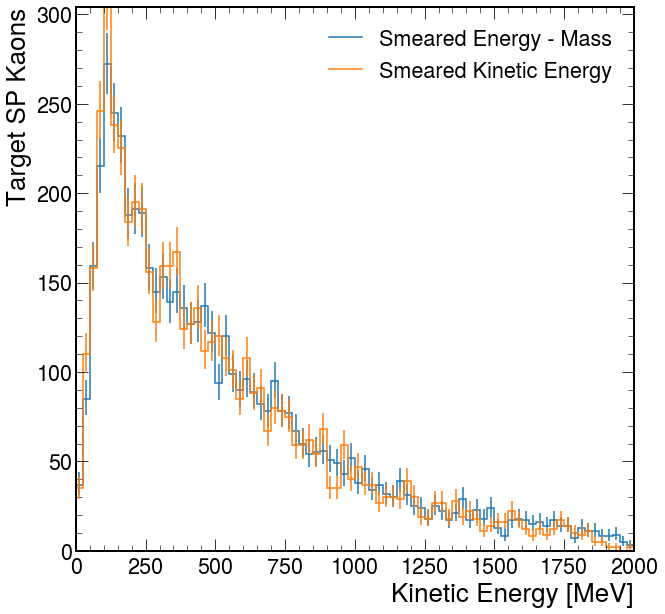

In [8]:
print(hists["Target_pion_ke"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_pion_ke"].sum('ke'),ax=ax,clear=False);
hist.plot1d(hists["Target_pion_ke"].sum('e'),ax=ax,clear=False);
leg = ax.legend([r'Smeared Energy - Mass', r'Smeared Kinetic Energy'])

#hist.plot1d(hists["Target_pion_ke_new"].sum('ke1'),ax=ax[1],clear=False);
#hist.plot1d(hists["Target_pion_ke_new"].sum('ke2'),ax=ax[1],clear=False);
#leg = ax[1].legend([r'Dau1 with Mass Smear', r'Dau2 with Mass Smear'])